# Submissions are evaluated using **area under the ROC curve** using the predicted probabilities and the ground truth targets.

In [1]:
!pip install lightgbm

# Required Imports

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, \
accuracy_score,f1_score, mean_absolute_error, mean_squared_error, r2_score
# all classifcation models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, \
GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth',400)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [3]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv',index_col = 'id')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv',index_col = 'id')
submission_data = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
print(train_data.shape, test_data.shape, submission_data.shape)
print(len(train_data), len(test_data), len(submission_data))

(11504798, 11) (7669866, 10) (7669866, 2)
11504798 7669866 7669866


In [4]:
print(train_data.shape)
train_data.drop_duplicates(inplace=True)
print(train_data.shape)

(11504798, 11)
(11504798, 11)


In [5]:
train_data.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,11504798.00000,11504798.00000,11504798.00000,11504798.00000,11504798.00000,11504798.00000,11504798.00000,11504798.00000
mean,38.38356,0.99802,26.41869,0.46300,30461.37041,112.42544,163.89774,0.12300
std,14.99346,0.04443,12.99159,0.49863,16454.74521,54.03571,79.97953,0.32843
min,20.00000,0.00000,0.00000,0.00000,2630.00000,1.00000,10.00000,0.00000
25%,24.00000,1.00000,15.00000,0.00000,25277.00000,29.00000,99.00000,0.00000
50%,36.00000,1.00000,28.00000,0.00000,31824.00000,151.00000,166.00000,0.00000
75%,49.00000,1.00000,35.00000,1.00000,39451.00000,152.00000,232.00000,0.00000
max,85.00000,1.00000,52.00000,1.00000,540165.00000,163.00000,299.00000,1.00000


In [6]:
train_data[:5]

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.00000,0,1-2 Year,Yes,65101.00000,124.00000,187,0
1,Male,43,1,28.00000,0,> 2 Years,Yes,58911.00000,26.00000,288,1
2,Female,25,1,14.00000,1,< 1 Year,No,38043.00000,152.00000,254,0
3,Female,35,1,1.00000,0,1-2 Year,Yes,2630.00000,156.00000,76,0
4,Female,36,1,15.00000,1,1-2 Year,No,31951.00000,152.00000,294,0


In [8]:
pd.set_option('display.max_colwidth',500)
train_data['Annual_Premium'].unique()

array([65101., 58911., 38043., ..., 22112., 54335., 64538.])

In [9]:
train_data.isna().count()

Gender                  11504798
Age                     11504798
Driving_License         11504798
Region_Code             11504798
Previously_Insured      11504798
Vehicle_Age             11504798
Vehicle_Damage          11504798
Annual_Premium          11504798
Policy_Sales_Channel    11504798
Vintage                 11504798
Response                11504798
dtype: int64

In [10]:
train_data['Response'].value_counts() 

Response
0    10089739
1     1415059
Name: count, dtype: int64

# Graph Plots

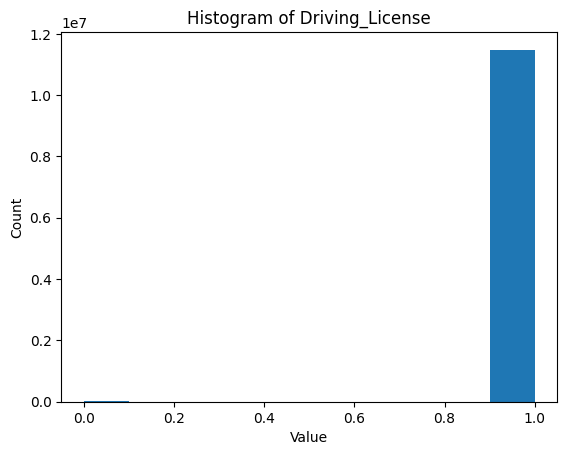

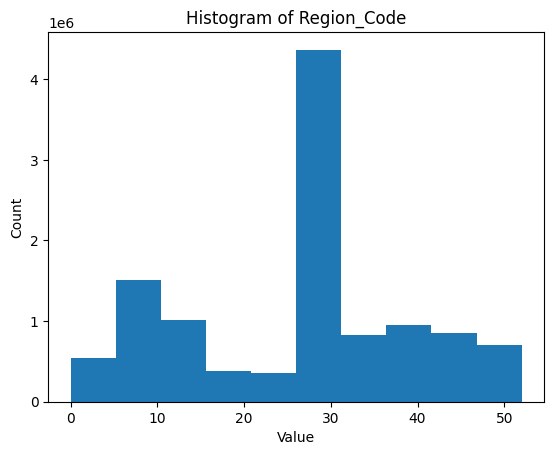

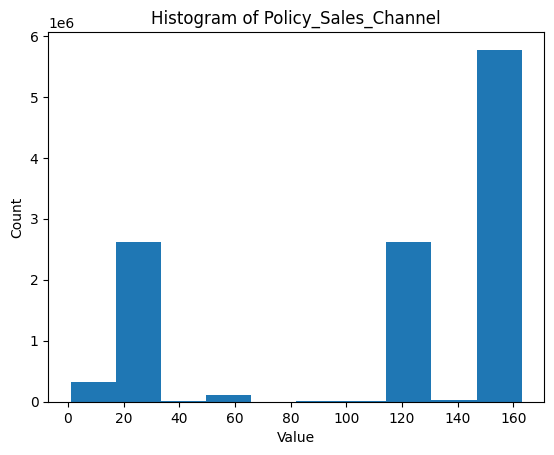

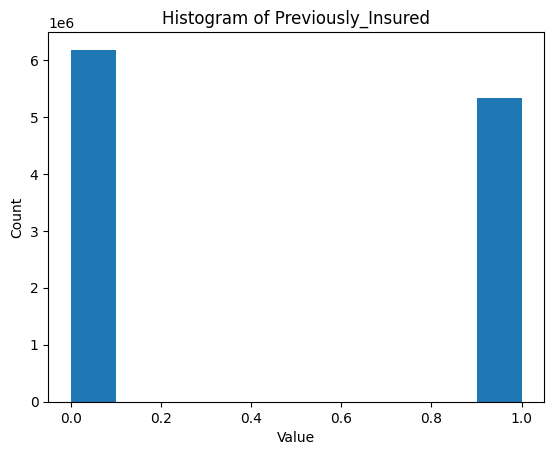

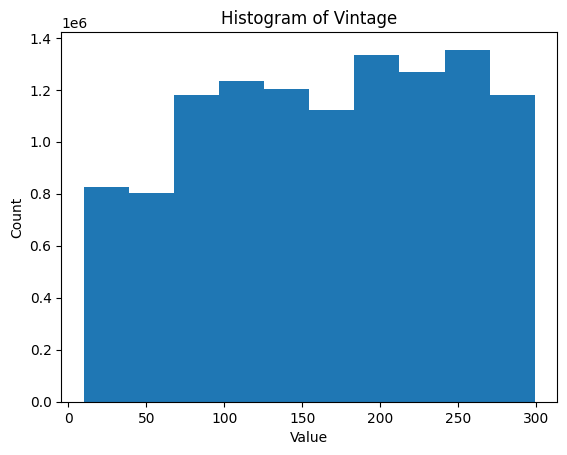

In [15]:
columns_to_plot = ['Driving_License', 'Region_Code', 'Policy_Sales_Channel',
                   'Previously_Insured', 'Vintage']

for column in columns_to_plot:
    ax = train_data[column].plot(kind='hist', title=f"Histogram of {column}")
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    plt.show()  

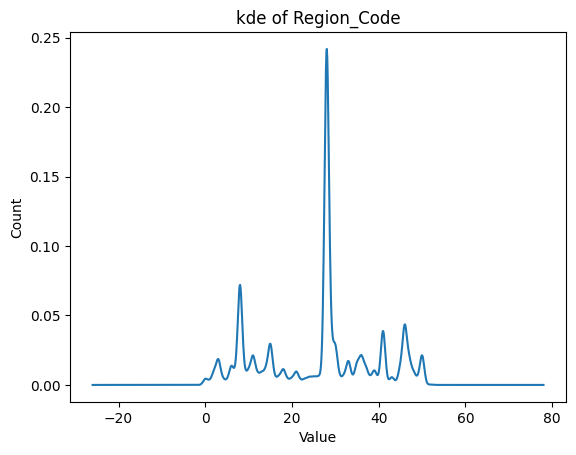

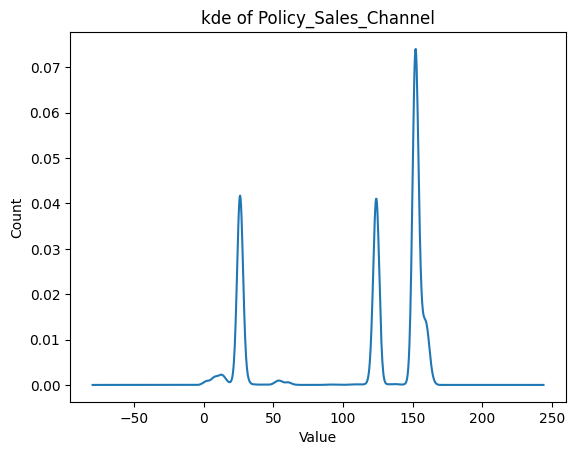

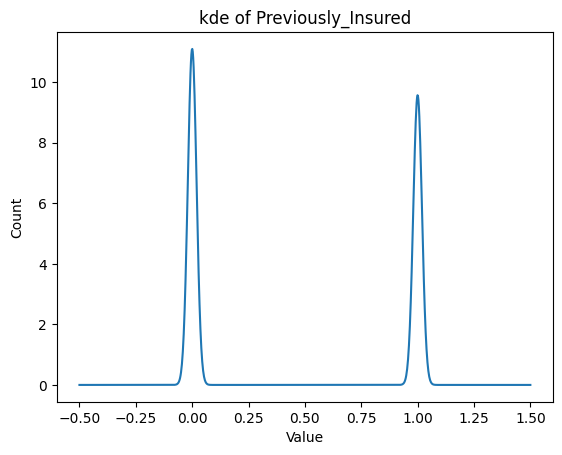

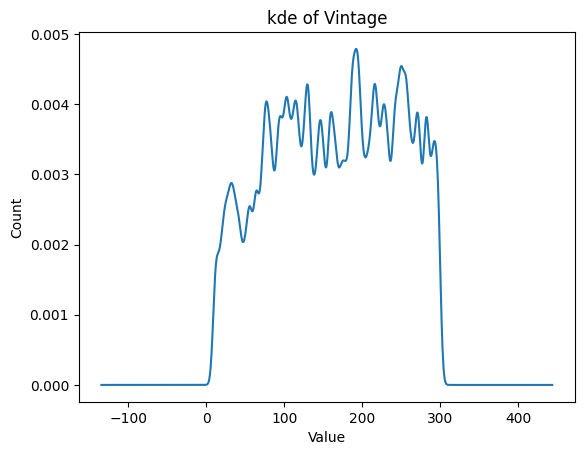

In [17]:
columns_to_plotKDE = ['Region_Code', 'Policy_Sales_Channel',
                   'Previously_Insured', 'Vintage']
for column in columns_to_plotKDE:
    ax = train_data[column].plot(kind='kde', title=f"kde of {column}")
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    plt.show() 

<Axes: >

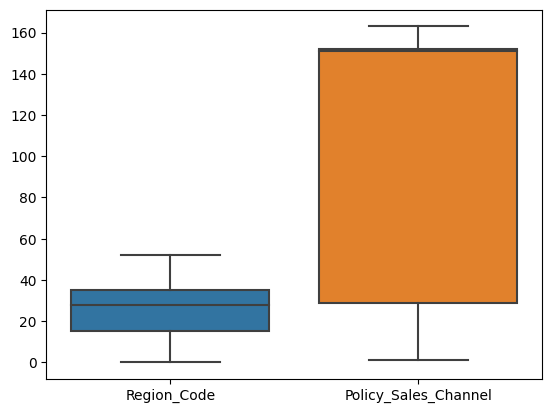

In [19]:
sns.boxplot(train_data[['Region_Code','Policy_Sales_Channel']])

# Removing outliers from Region_Code and Policy_Sales_Channel

In [31]:

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = train_data
df_cleaned = remove_outliers(df, 'Region_Code')
df_cleaned = remove_outliers(df_cleaned, 'Policy_Sales_Channel')

In [32]:
df_cleaned

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.00000,0,1-2 Year,Yes,65101.00000,124.00000,187,0
1,Male,43,1,28.00000,0,> 2 Years,Yes,58911.00000,26.00000,288,1
2,Female,25,1,14.00000,1,< 1 Year,No,38043.00000,152.00000,254,0
3,Female,35,1,1.00000,0,1-2 Year,Yes,2630.00000,156.00000,76,0
4,Female,36,1,15.00000,1,1-2 Year,No,31951.00000,152.00000,294,0
...,...,...,...,...,...,...,...,...,...,...,...
11504793,Male,48,1,6.00000,0,1-2 Year,Yes,27412.00000,26.00000,218,0
11504794,Female,26,1,36.00000,0,< 1 Year,Yes,29509.00000,152.00000,115,1
11504795,Female,29,1,32.00000,1,< 1 Year,No,2630.00000,152.00000,189,0


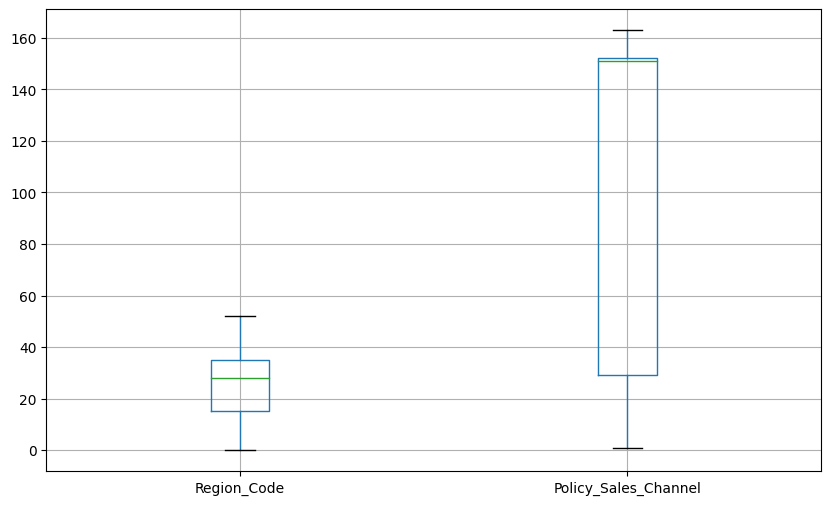

In [34]:
plt.figure(figsize=(10, 6))
df_cleaned.boxplot(column=['Region_Code', 'Policy_Sales_Channel'])
plt.show()

In [30]:
df_cleaned.shape

(11504798, 11)

In [35]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB


# Pre-processing the data

In [37]:
categorical_features = ['Gender','Vehicle_Age','Vehicle_Damage']
numerical_features = ['Age','Region_Code','Annual_Premium','Policy_Sales_Channel','Vintage']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features)
])

In [38]:
transformed_data = preprocessor.fit_transform(df_cleaned)
test_transformed_data = preprocessor.fit_transform(test_data)

In [39]:
transformed_data.shape, test_transformed_data.shape

((11504798, 12), (7669866, 12))

In [40]:
ohe_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
num_columns = numerical_features
all_columns = list(num_columns) + list(ohe_columns)
train_data_transformed = pd.DataFrame(transformed_data, columns=all_columns)
test_data_transformed = pd.DataFrame(test_transformed_data, columns=all_columns)

In [41]:
print(train_data_transformed.shape, test_data_transformed.shape)
print(train_data.columns,train_data_transformed.columns)
print(test_data.columns,test_data_transformed.columns)

(11504798, 12) (7669866, 12)
Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object') Index(['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel',
       'Vintage', 'Gender_Female', 'Gender_Male', 'Vehicle_Age_1-2 Year',
       'Vehicle_Age_< 1 Year', 'Vehicle_Age_> 2 Years', 'Vehicle_Damage_No',
       'Vehicle_Damage_Yes'],
      dtype='object')
Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage'],
      dtype='object') Index(['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel',
       'Vintage', 'Gender_Female', 'Gender_Male', 'Vehicle_Age_1-2 Year',
       'Vehicle_Age_< 1 Year', 'Vehicle_Age_> 2 Years', 'Vehicle_Damage_No',
       'Vehicle_Damage_Yes'],
      dtype='object')


In [42]:
train_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.00000,0,1-2 Year,Yes,65101.00000,124.00000,187,0
1,Male,43,1,28.00000,0,> 2 Years,Yes,58911.00000,26.00000,288,1
2,Female,25,1,14.00000,1,< 1 Year,No,38043.00000,152.00000,254,0
3,Female,35,1,1.00000,0,1-2 Year,Yes,2630.00000,156.00000,76,0
4,Female,36,1,15.00000,1,1-2 Year,No,31951.00000,152.00000,294,0


In [43]:
train_data_transformed.head()

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes
0,-1.15941,0.66053,2.10515,0.21420,0.28885,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000
1,0.30790,0.12172,1.72896,-1.59941,1.55168,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000
2,-0.89263,-0.95590,0.46076,0.73238,1.12657,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000
3,-0.22567,-1.95655,-1.69139,0.80640,-1.09900,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000
4,-0.15897,-0.87893,0.09053,0.73238,1.62669,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000


In [44]:
train_data_new = pd.concat([train_data_transformed, train_data[['Driving_License', 'Previously_Insured','Response']]], axis=1)
train_data_new.head()

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes,Driving_License,Previously_Insured,Response
0,-1.15941,0.66053,2.10515,0.21420,0.28885,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1,0,0
1,0.30790,0.12172,1.72896,-1.59941,1.55168,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,1,0,1
2,-0.89263,-0.95590,0.46076,0.73238,1.12657,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1,1,0
3,-0.22567,-1.95655,-1.69139,0.80640,-1.09900,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1,0,0
4,-0.15897,-0.87893,0.09053,0.73238,1.62669,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1,1,0


# Test Data processing

In [50]:
test_data = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')
test_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.00000,0,< 1 Year,No,2630.00000,160.00000,228
1,11504799,Male,47,1,28.00000,0,1-2 Year,Yes,37483.00000,124.00000,123
2,11504800,Male,47,1,43.00000,0,1-2 Year,Yes,2630.00000,26.00000,271
3,11504801,Female,22,1,47.00000,1,< 1 Year,No,24502.00000,152.00000,115
4,11504802,Male,51,1,19.00000,0,1-2 Year,No,34115.00000,124.00000,148


In [52]:
test_transform = preprocessor.fit_transform(test_data)

In [53]:
test_data_transformed = pd.DataFrame(test_transform, columns=all_columns)

In [54]:
test_data_transformed[:5]

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes
0,-1.22613,1.58326,-1.69255,0.88093,0.80141,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000
1,0.57393,0.12108,0.42670,0.21517,-0.51134,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000
2,0.57393,1.27543,-1.69255,-1.59718,1.33902,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000
3,-1.09279,1.58326,-0.36262,0.73298,-0.61136,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000
4,0.84060,-0.57153,0.22191,0.21517,-0.19878,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000


In [55]:
test_data_new = pd.concat([test_data_transformed, test_data[['id','Driving_License', 'Previously_Insured']]], axis=1)
test_data_new.head()

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes,id,Driving_License,Previously_Insured
0,-1.22613,1.58326,-1.69255,0.88093,0.80141,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,11504798,1,0
1,0.57393,0.12108,0.42670,0.21517,-0.51134,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,11504799,1,0
2,0.57393,1.27543,-1.69255,-1.59718,1.33902,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,11504800,1,0
3,-1.09279,1.58326,-0.36262,0.73298,-0.61136,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,11504801,1,1
4,0.84060,-0.57153,0.22191,0.21517,-0.19878,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,11504802,1,0


In [56]:
test_data_new.set_index('id', inplace=True)

In [57]:
test_data_new

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes,Driving_License,Previously_Insured
id,,,,,,,,,,,,,,
11504798,-1.22613,1.58326,-1.69255,0.88093,0.80141,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1,0
11504799,0.57393,0.12108,0.42670,0.21517,-0.51134,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1,0
11504800,0.57393,1.27543,-1.69255,-1.59718,1.33902,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1,0
11504801,-1.09279,1.58326,-0.36262,0.73298,-0.61136,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1,1
11504802,0.84060,-0.57153,0.22191,0.21517,-0.19878,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19174659,1.24062,0.12108,1.28880,0.21517,-0.68638,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1,0
19174660,-0.69278,1.81413,-0.29275,0.73298,0.25130,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1,1
19174661,0.57393,0.50587,-1.69255,0.47408,-1.26149,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1,1


<Axes: >

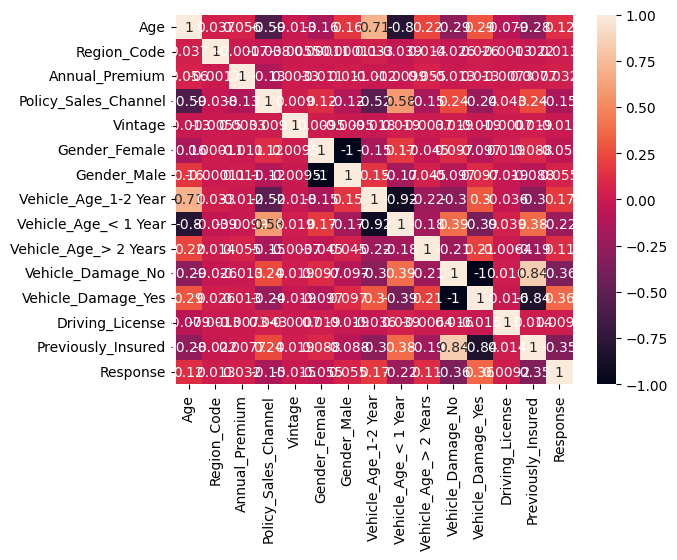

In [58]:
# sns.heatmap(train_data,annot=True,linecolor='red',)
sns.heatmap(train_data_new.corr(),annot=True)

<Axes: >

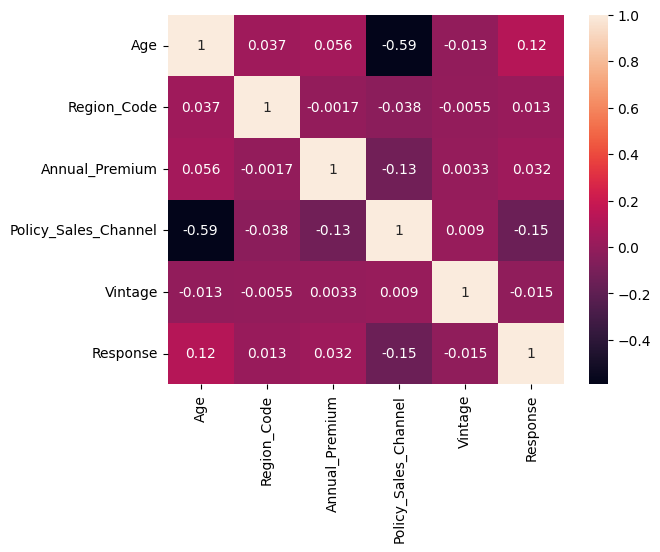

In [59]:
sns.heatmap(train_data[['Age','Region_Code','Annual_Premium','Policy_Sales_Channel','Vintage','Response']].corr(),annot=True)

# Training and Testing

In [61]:
X = train_data_new.drop('Response',axis=1)
y = train_data_new['Response']
X[:5],y[:5]

(       Age  Region_Code  Annual_Premium  Policy_Sales_Channel  Vintage  \
 0 -1.15941      0.66053         2.10515               0.21420  0.28885   
 1  0.30790      0.12172         1.72896              -1.59941  1.55168   
 2 -0.89263     -0.95590         0.46076               0.73238  1.12657   
 3 -0.22567     -1.95655        -1.69139               0.80640 -1.09900   
 4 -0.15897     -0.87893         0.09053               0.73238  1.62669   
 
    Gender_Female  Gender_Male  Vehicle_Age_1-2 Year  Vehicle_Age_< 1 Year  \
 0        0.00000      1.00000               1.00000               0.00000   
 1        0.00000      1.00000               0.00000               0.00000   
 2        1.00000      0.00000               0.00000               1.00000   
 3        1.00000      0.00000               1.00000               0.00000   
 4        1.00000      0.00000               1.00000               0.00000   
 
    Vehicle_Age_> 2 Years  Vehicle_Damage_No  Vehicle_Damage_Yes  \
 0        

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

# Models

In [70]:
from lightgbm import LGBMClassifier

clf3 = GaussianNB()
clf1 = LogisticRegression()
clf2 = RandomForestClassifier(n_estimators=1000,criterion='gini')
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(criterion='gini',min_samples_split=2),
    'RandomForest': RandomForestClassifier(n_estimators=1000,criterion='gini'),
    'GradientBoosting': GradientBoostingClassifier(learning_rate=0.0005,n_estimators=1000,max_depth=10),
    'AdaBoostClassifier': AdaBoostClassifier(n_estimators=100),
    'VotingClassifer': VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)],voting='hard')
}

In [ ]:
mse_list = []
roc_auc_list=[]
roc_list=[]
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("#"*40)
    mse = mean_squared_error(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    roc_score = roc_curve(y_test,y_pred)
    mse_list.append(mse)
    roc_auc_list.append(roc_auc)
    roc_list.append(roc_score)
    print(f"{name} Mean Squared Error: {mse}")
    print(f"{name} roc auc: {roc_auc}")
    print(f"{name} roc curve: {roc_score}")
    print("*"*40)

########################################
LogisticRegression Mean Squared Error: 0.12318901675822265
LogisticRegression roc auc: 0.500045662530994
LogisticRegression roc curve: (array([0.00000000e+00, 1.69989137e-04, 1.00000000e+00]), array([0.00000000e+00, 2.61314199e-04, 1.00000000e+00]), array([2, 1, 0]))
****************************************
########################################
DecisionTree Mean Squared Error: 0.1675457200472846
DecisionTree roc auc: 0.621809002749728
DecisionTree roc curve: (array([0.        , 0.09876716, 1.        ]), array([0.        , 0.34238516, 1.        ]), array([2, 1, 0]))
****************************************


In [ ]:
mse_list,roc_auc_list,roc_list

# LightGBM

In [66]:
lgb_model = LGBMClassifier(learning_rate=0.0005)
lgb_model.fit(X_train,y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1131875, number of negative: 8071963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.761427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 726
[LightGBM] [Info] Number of data points in the train set: 9203838, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122979 -> initscore=-1.964521
[LightGBM] [Info] Start training from score -1.964521


LGBMClassifier(learning_rate=0.03)

In [67]:
y_pred_lgb = lgb_model.predict(X_test)

In [68]:
lgb_mse = mean_squared_error(y_test, y_pred_lgb)
lgb_roc_auc = roc_auc_score(y_test, y_pred_lgb)
lgb_roc_score = roc_curve(y_test, y_pred_lgb)
print(f'Mean Squared Error: {lgb_mse}')
print(f'roc_auc: {lgb_roc_auc}')
print(f'roc_score: {lgb_roc_score}')

Mean Squared Error: 0.12247931298240734
roc_auc: 0.5041325931462199
roc_score: (array([0.00000000e+00, 5.62996091e-04, 1.00000000e+00]), array([0.        , 0.00882818, 1.        ]), array([2, 1, 0]))
